In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(3285, 4, 32, 9) (1387, 4, 32, 9)


In [16]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 14s 34ms/step - loss: 0.8942 - accuracy: 0.5802 - val_loss: 0.5764 - val_accuracy: 0.7769
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: 0.4669 - accuracy: 0.8222 - val_loss: 0.3682 - val_accuracy: 0.8631
Epoch 3/10
26/26 [==============================] - 0s 8ms/step - loss: 0.2234 - accuracy: 0.9224 - val_loss: 0.1067 - val_accuracy: 0.9767
Epoch 4/10
26/26 [==============================] - 0s 10ms/step - loss: 0.1166 - accuracy: 0.9583 - val_loss: 0.0751 - val_accuracy: 0.9828
Epoch 5/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0647 - accuracy: 0.9811 - val_loss: 0.0315 - val_accuracy: 0.9970
Epoch 6/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0399 - accuracy: 0.9875 - val_loss: 0.0163 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.0160 - val_accuracy: 0.9970
Epoch 8/10
26/

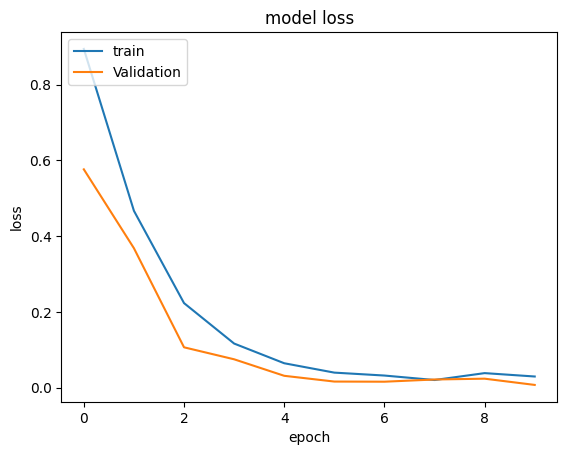

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

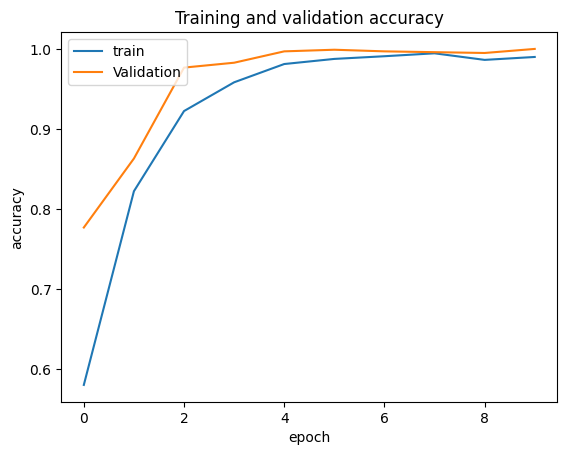

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 3ms/step
[[449  12  35]
 [  2 442  27]
 [  7   1 412]]
0.93943763518385
0.9398961348266623
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       496
           1       0.97      0.94      0.95       471
           2       0.87      0.98      0.92       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

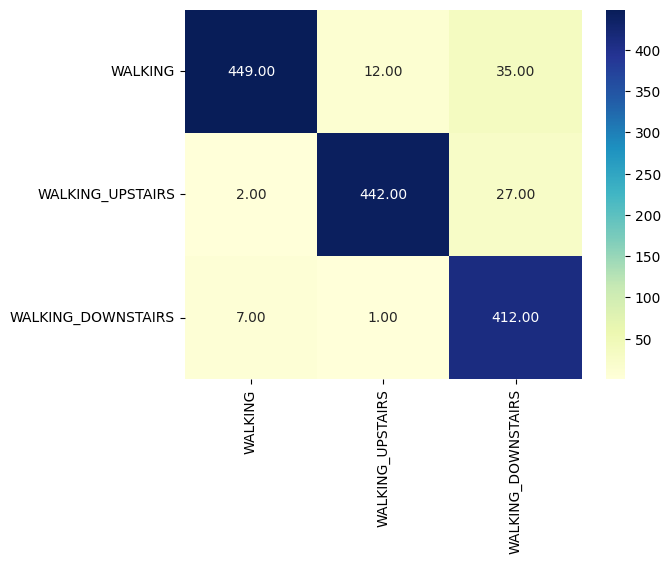

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer 3

# CNN 1 - LSTM2



In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_57 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_58 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_59 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_13 (LSTM)              (None, None, 100)        

In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 40ms/step - loss: 0.9854 - accuracy: 0.4980 - val_loss: 0.7493 - val_accuracy: 0.6694
Epoch 2/10
26/26 [==============================] - 0s 10ms/step - loss: 0.5578 - accuracy: 0.7781 - val_loss: 0.3598 - val_accuracy: 0.8763
Epoch 3/10
26/26 [==============================] - 0s 11ms/step - loss: 0.2903 - accuracy: 0.8959 - val_loss: 0.1546 - val_accuracy: 0.9584
Epoch 4/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1383 - accuracy: 0.9525 - val_loss: 0.0696 - val_accuracy: 0.9777
Epoch 5/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0846 - accuracy: 0.9689 - val_loss: 0.0389 - val_accuracy: 0.9899
Epoch 6/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0395 - accuracy: 0.9866 - val_loss: 0.0176 - val_accuracy: 0.9949
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0382 - accuracy: 0.9896 - val_loss: 0.0237 - val_accuracy: 0.9919
Epoch 8/10
26/26

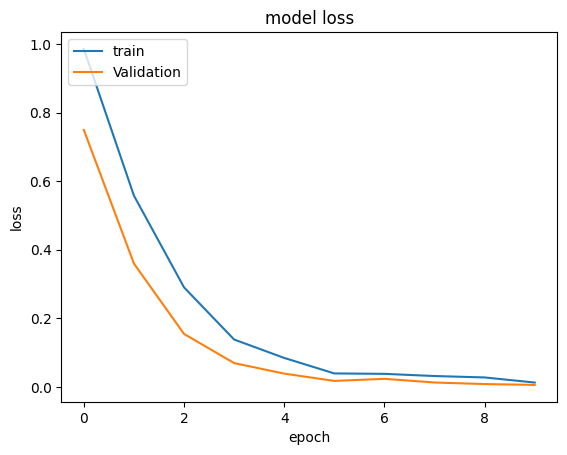

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

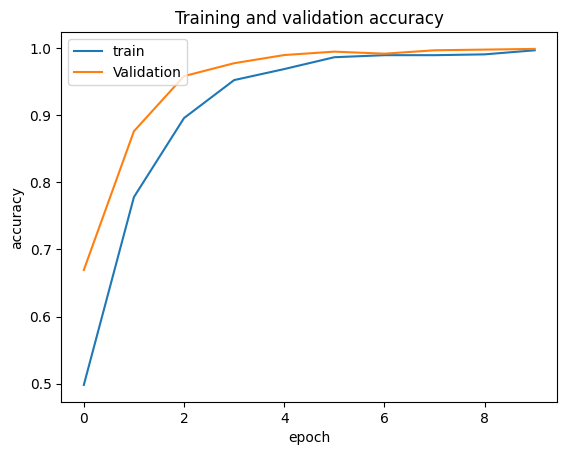

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 3ms/step
[[456   1  39]
 [ 11 428  32]
 [  9   1 410]]
0.9329488103821196
0.9337424708430941
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       496
           1       1.00      0.91      0.95       471
           2       0.85      0.98      0.91       420

    accuracy                           0.93      1387
   macro avg       0.94      0.93      0.93      1387
weighted avg       0.94      0.93      0.93      1387



<Axes: >

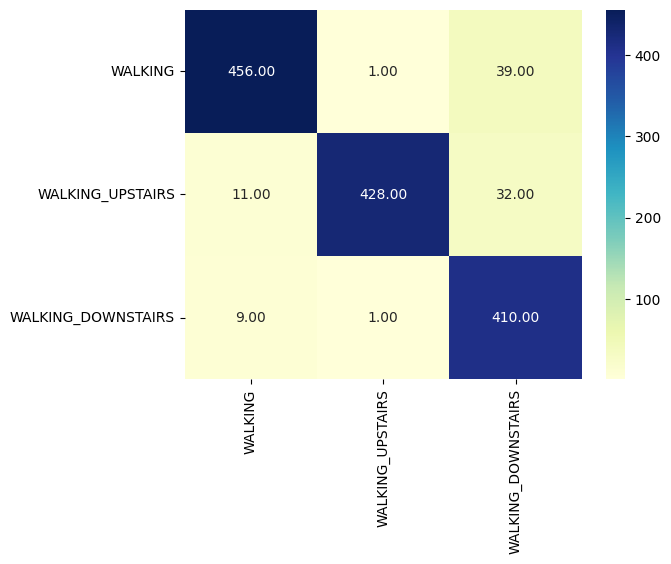

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_61 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_62 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_63 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_64 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 4s 44ms/step - loss: 0.9531 - accuracy: 0.5318 - val_loss: 0.6748 - val_accuracy: 0.7424
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 0.3507 - accuracy: 0.8810 - val_loss: 0.1493 - val_accuracy: 0.9564
Epoch 3/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1113 - accuracy: 0.9641 - val_loss: 0.0408 - val_accuracy: 0.9959
Epoch 4/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0391 - accuracy: 0.9860 - val_loss: 0.0218 - val_accuracy: 0.9970
Epoch 5/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0198 - accuracy: 0.9945 - val_loss: 0.0164 - val_accuracy: 0.9990
Epoch 6/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0787 - accuracy: 0.9741 - val_loss: 0.0388 - val_accuracy: 0.9970
Epoch 8/10
26

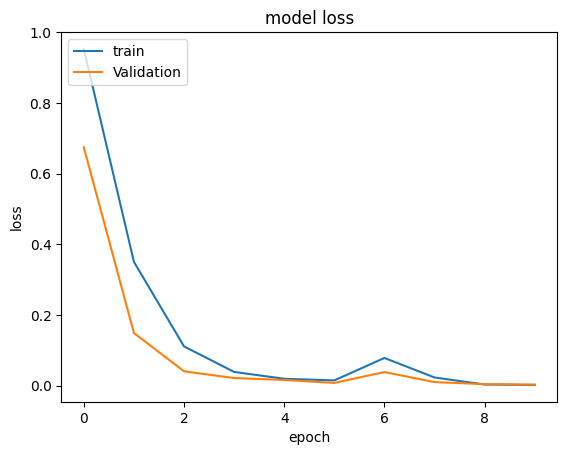

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

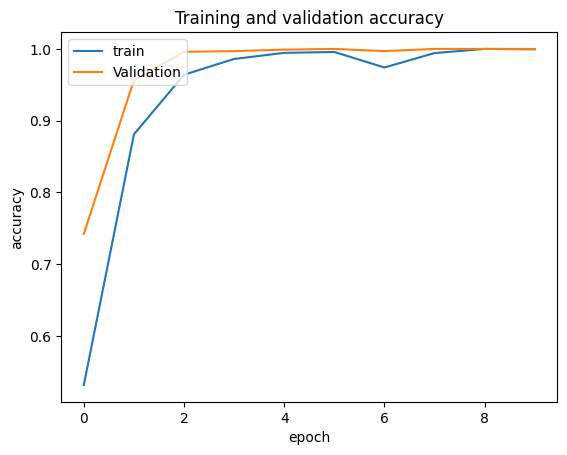

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 0s 3ms/step
[[467   1  28]
 [  4 433  34]
 [  1   0 419]]
0.9509733237202596
0.9516322316065524
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       1.00      0.92      0.96       471
           2       0.87      1.00      0.93       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.96      0.95      0.95      1387



<Axes: >

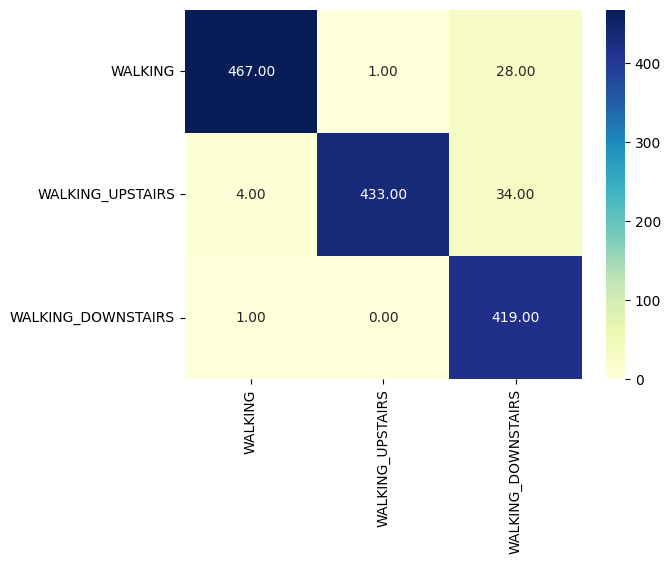

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer4

# CNN1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_68 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_16 (LSTM)              (None, None, 100)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 55ms/step - loss: 1.0435 - accuracy: 0.4584 - val_loss: 0.8967 - val_accuracy: 0.6116
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6491 - accuracy: 0.7473 - val_loss: 0.3958 - val_accuracy: 0.8631
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 0.3646 - accuracy: 0.8697 - val_loss: 0.2107 - val_accuracy: 0.9462
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 0.1932 - accuracy: 0.9406 - val_loss: 0.1162 - val_accuracy: 0.9645
Epoch 5/10
26/26 [==============================] - 0s 12ms/step - loss: 0.1211 - accuracy: 0.9607 - val_loss: 0.0642 - val_accuracy: 0.9868
Epoch 6/10
26/26 [==============================] - 0s 16ms/step - loss: 0.0996 - accuracy: 0.9665 - val_loss: 0.0672 - val_accuracy: 0.9838
Epoch 7/10
26/26 [==============================] - 0s 15ms/step - loss: 0.0503 - accuracy: 0.9817 - val_loss: 0.0266 - val_accuracy: 0.9909
Epoch 8/10
26

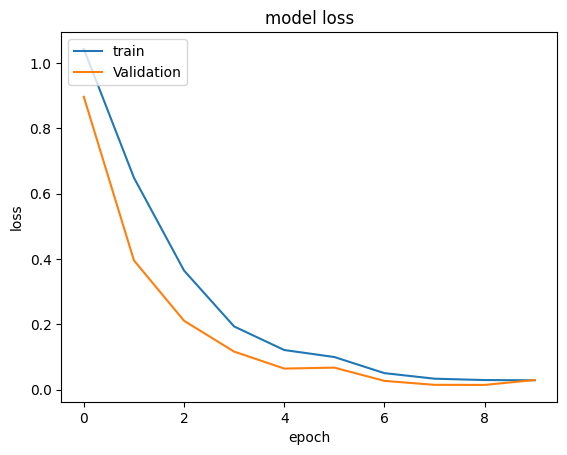

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

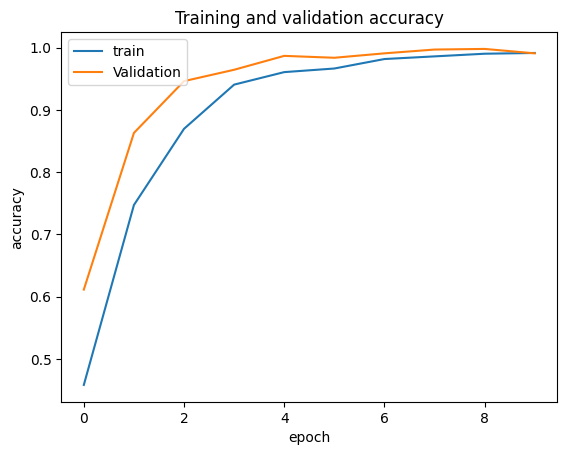

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[422   8  66]
 [  0 438  33]
 [  1   1 418]]
0.9214131218457101
0.9226388276597518
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       496
           1       0.98      0.93      0.95       471
           2       0.81      1.00      0.89       420

    accuracy                           0.92      1387
   macro avg       0.93      0.93      0.92      1387
weighted avg       0.93      0.92      0.92      1387



<Axes: >

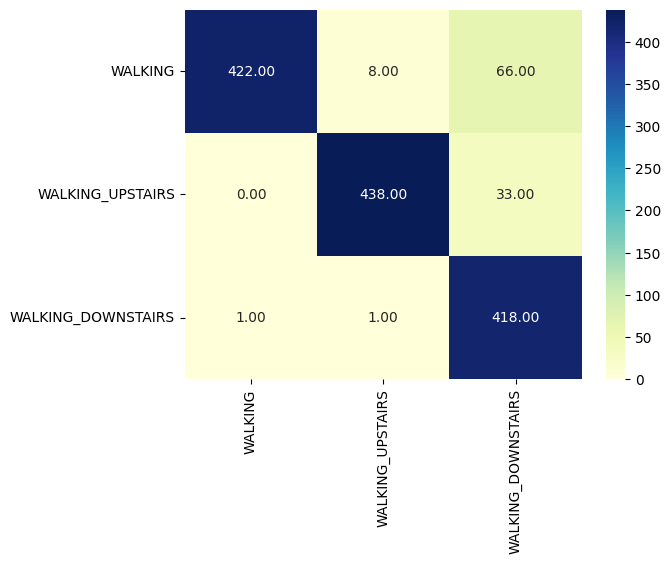

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_69 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_70 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_71 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_72 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_73 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 57ms/step - loss: 0.9858 - accuracy: 0.5050 - val_loss: 0.6803 - val_accuracy: 0.7201
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 0.4766 - accuracy: 0.8164 - val_loss: 0.2984 - val_accuracy: 0.9158
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 0.1641 - accuracy: 0.9510 - val_loss: 0.0966 - val_accuracy: 0.9726
Epoch 4/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0720 - accuracy: 0.9756 - val_loss: 0.0580 - val_accuracy: 0.9817
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0880 - accuracy: 0.9708 - val_loss: 0.0533 - val_accuracy: 0.9868
Epoch 6/10
26/26 [==============================] - 0s 15ms/step - loss: 0.0374 - accuracy: 0.9869 - val_loss: 0.0153 - val_accuracy: 0.9980
Epoch 7/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0071 - val_accuracy: 0.9990
Epoch 8/10
26

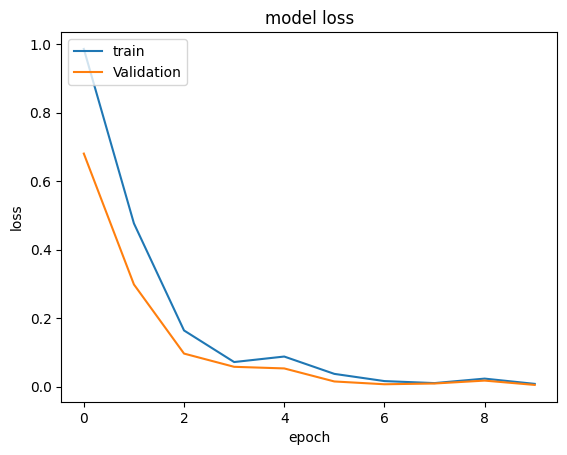

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

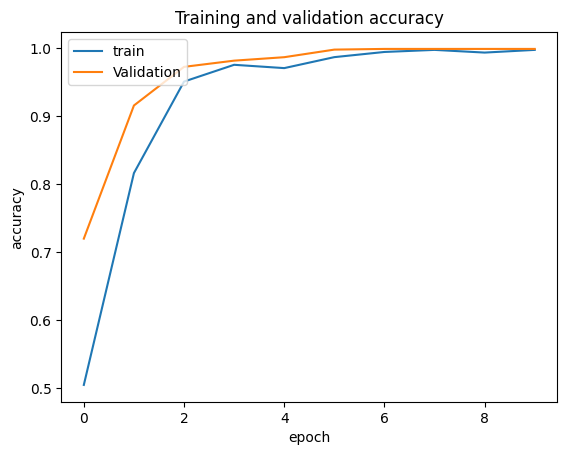

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 3ms/step
[[468   4  24]
 [  4 440  27]
 [ 14   5 401]]
0.9437635183850036
0.9441758665567502
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.98      0.93      0.96       471
           2       0.89      0.95      0.92       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.95      0.94      0.94      1387



<Axes: >

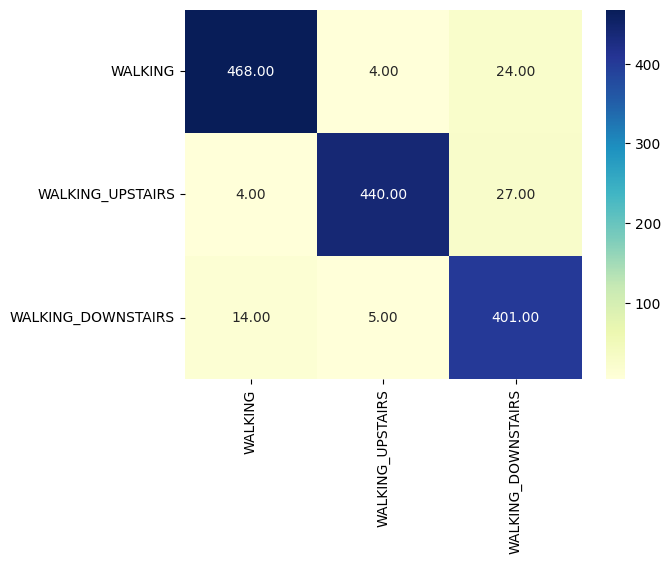

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_42 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_43 (TimeD  (None, None, 12, 64)     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 4s 33ms/step - loss: 1.0074 - accuracy: 0.4776 - val_loss: 0.8029 - val_accuracy: 0.6714
Epoch 2/10
26/26 [==============================] - 0s 10ms/step - loss: 0.5633 - accuracy: 0.7738 - val_loss: 0.4653 - val_accuracy: 0.8732
Epoch 3/10
26/26 [==============================] - 0s 9ms/step - loss: 0.2465 - accuracy: 0.9126 - val_loss: 0.1777 - val_accuracy: 0.9807
Epoch 4/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1066 - accuracy: 0.9696 - val_loss: 0.0973 - val_accuracy: 0.9919
Epoch 5/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0587 - accuracy: 0.9814 - val_loss: 0.0717 - val_accuracy: 0.9980
Epoch 6/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0398 - accuracy: 0.9872 - val_loss: 0.0749 - val_accuracy: 0.9929
Epoch 7/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0245 - accuracy: 0.9927 - val_loss: 0.0339 - val_accuracy: 0.9980
Epoch 8/10
26/2

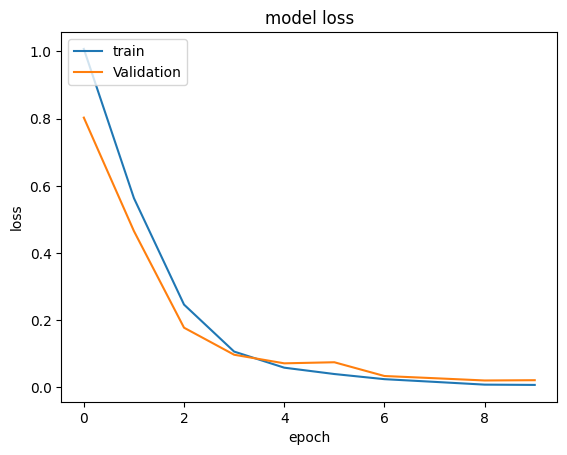

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

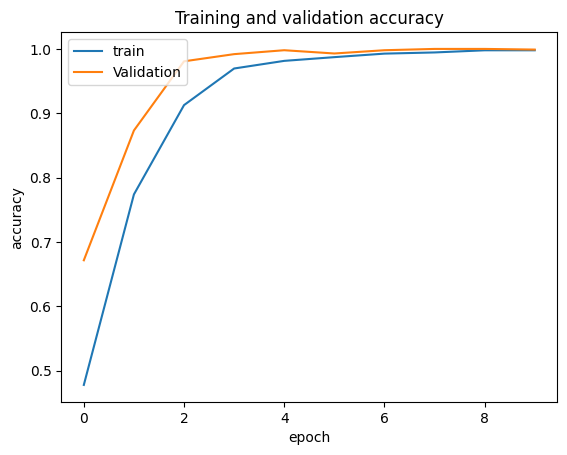

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[435  18  43]
 [  0 462   9]
 [  1   3 416]]
0.946647440519106
0.9464358216325092
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       496
           1       0.96      0.98      0.97       471
           2       0.89      0.99      0.94       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

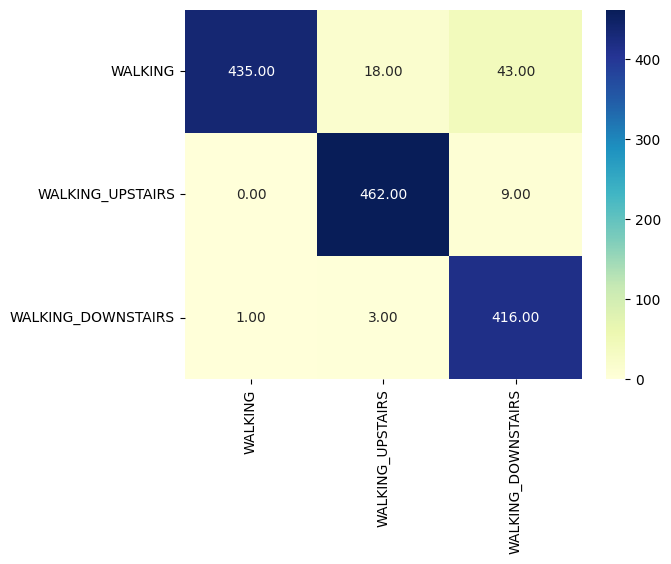

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer5

# CNN

# C4 L1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_74 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_75 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_76 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_77 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_78 (TimeD  (None, None, 12, 64)    

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 46ms/step - loss: 0.9995 - accuracy: 0.4731 - val_loss: 0.8336 - val_accuracy: 0.6156
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: 0.5843 - accuracy: 0.7537 - val_loss: 0.4301 - val_accuracy: 0.8996
Epoch 3/10
26/26 [==============================] - 0s 11ms/step - loss: 0.2672 - accuracy: 0.9005 - val_loss: 0.2104 - val_accuracy: 0.9736
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 0.1424 - accuracy: 0.9516 - val_loss: 0.1371 - val_accuracy: 0.9858
Epoch 5/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0564 - accuracy: 0.9814 - val_loss: 0.0518 - val_accuracy: 0.9949
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.0458 - val_accuracy: 0.9949
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 0.9915 - val_loss: 0.0369 - val_accuracy: 0.9980
Epoch 8/10
26

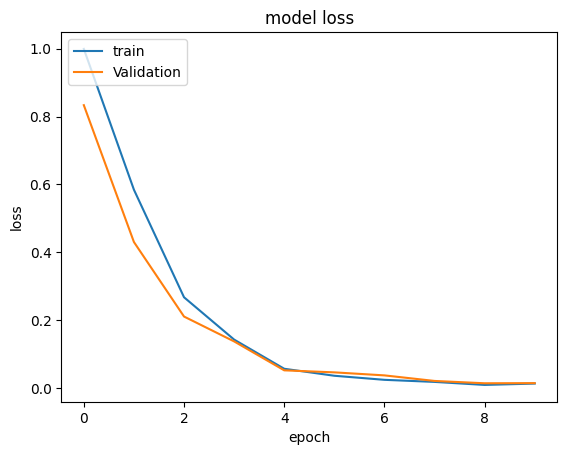

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

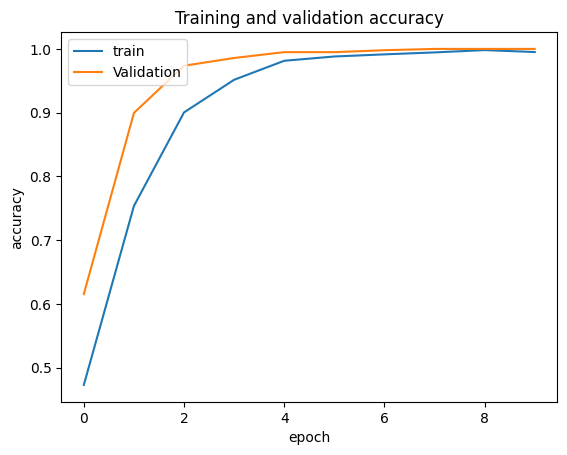

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 3ms/step
[[475   4  17]
 [  6 441  24]
 [  9   5 406]]
0.9531362653208363
0.9533541762857657
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       496
           1       0.98      0.94      0.96       471
           2       0.91      0.97      0.94       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

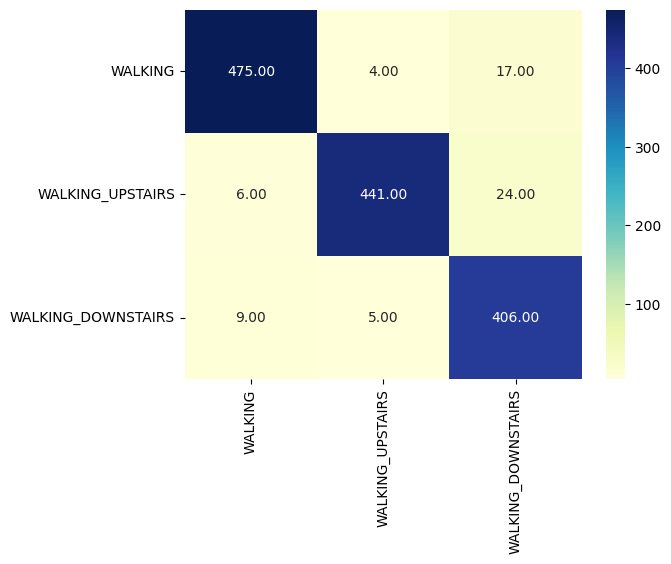

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')



# CNN3 - LSTM2

In [43]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_32 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_33 (TimeD  (None, None, 12, 64)     

In [44]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 48ms/step - loss: 1.0704 - accuracy: 0.4231 - val_loss: 0.9812 - val_accuracy: 0.6907
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 0.5964 - accuracy: 0.7619 - val_loss: 0.4070 - val_accuracy: 0.8945
Epoch 3/10
26/26 [==============================] - 0s 12ms/step - loss: 0.2003 - accuracy: 0.9352 - val_loss: 0.1584 - val_accuracy: 0.9777
Epoch 4/10
26/26 [==============================] - 0s 12ms/step - loss: 0.1522 - accuracy: 0.9525 - val_loss: 0.2020 - val_accuracy: 0.9777
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0802 - accuracy: 0.9732 - val_loss: 0.0989 - val_accuracy: 0.9939
Epoch 6/10
26/26 [==============================] - 0s 11ms/step - loss: 0.0396 - accuracy: 0.9881 - val_loss: 0.0446 - val_accuracy: 0.9959
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0323 - accuracy: 0.9909 - val_loss: 0.0460 - val_accuracy: 0.9959
Epoch 8/10
26

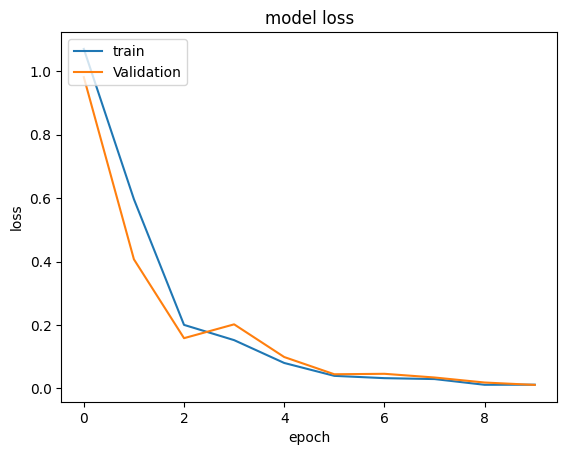

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

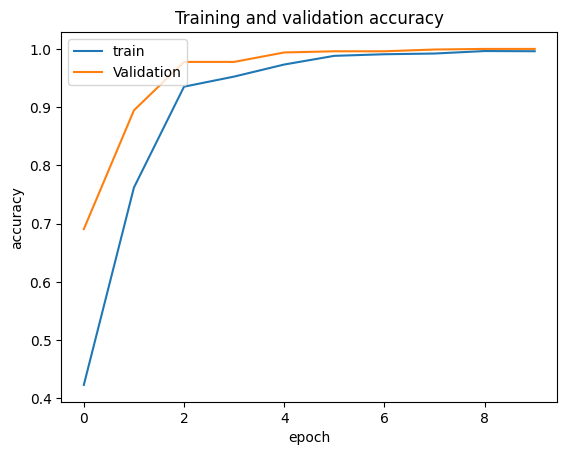

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[474   0  22]
 [  5 436  30]
 [  4   0 416]]
0.9560201874549387
0.9564761269275701
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       496
           1       1.00      0.93      0.96       471
           2       0.89      0.99      0.94       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

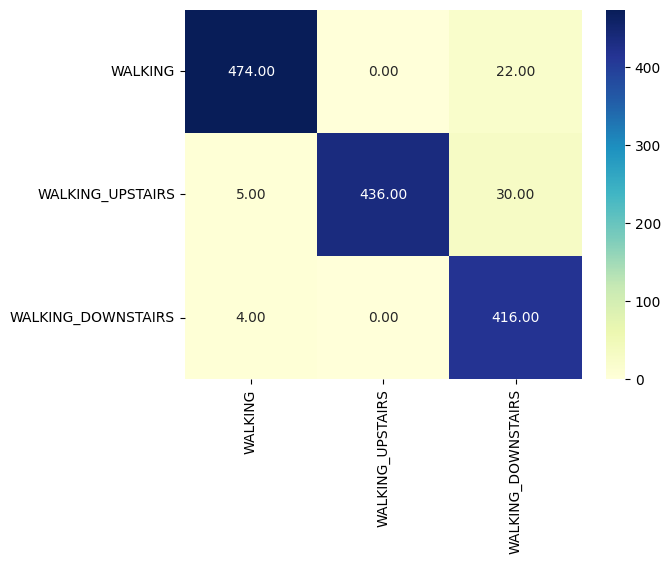

In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')



# CNN2 - LSTM3

In [21]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 896)        

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 11s 54ms/step - loss: 1.0689 - accuracy: 0.4359 - val_loss: 0.9272 - val_accuracy: 0.6136
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 0.6135 - accuracy: 0.7580 - val_loss: 0.3016 - val_accuracy: 0.9128
Epoch 3/10
26/26 [==============================] - 0s 12ms/step - loss: 0.2306 - accuracy: 0.9254 - val_loss: 0.1354 - val_accuracy: 0.9615
Epoch 4/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0929 - accuracy: 0.9705 - val_loss: 0.0755 - val_accuracy: 0.9757
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0553 - accuracy: 0.9820 - val_loss: 0.0448 - val_accuracy: 0.9899
Epoch 6/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0354 - accuracy: 0.9884 - val_loss: 0.0387 - val_accuracy: 0.9878
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.0152 - val_accuracy: 0.9949
Epoch 8/10
2

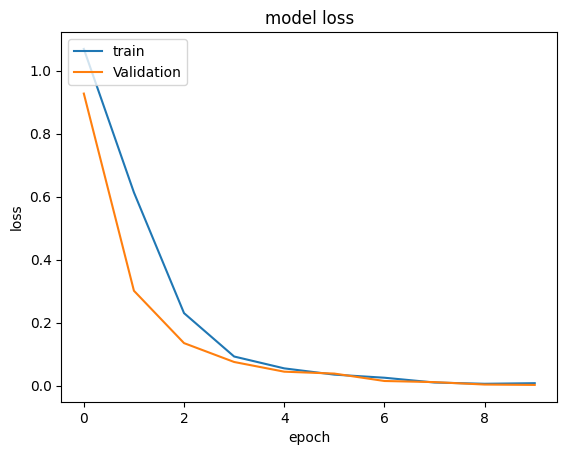

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

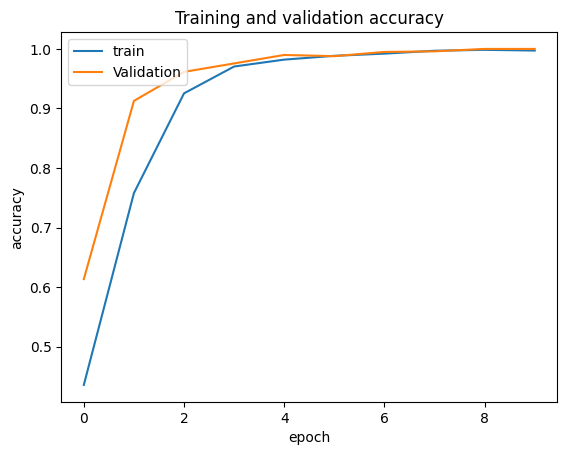

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
[[450   7  39]
 [  8 436  27]
 [  2   0 418]]
0.9401586157173756
0.9406700506857902
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       496
           1       0.98      0.93      0.95       471
           2       0.86      1.00      0.92       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.95      0.94      0.94      1387



<Axes: >

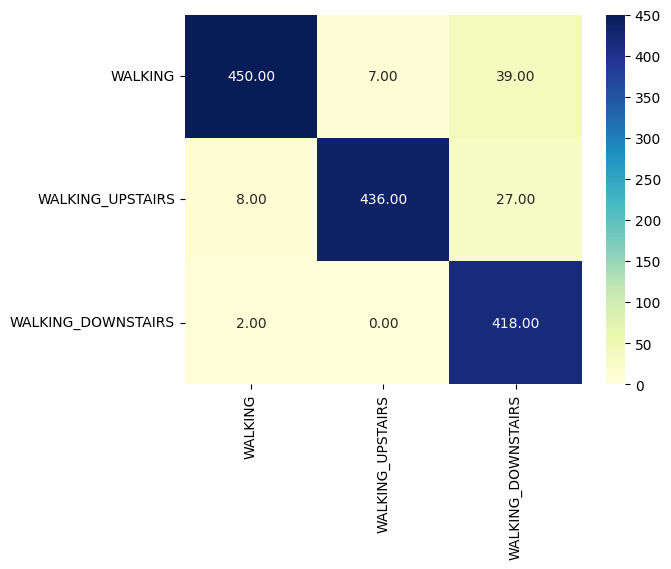

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')



# CNN1 - LSTM4

In [38]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_10 (LSTM)              (None, None, 100)        

In [39]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 16s 144ms/step - loss: 1.0675 - accuracy: 0.4186 - val_loss: 0.9339 - val_accuracy: 0.5842
Epoch 2/10
26/26 [==============================] - 1s 22ms/step - loss: 0.6922 - accuracy: 0.7114 - val_loss: 0.4454 - val_accuracy: 0.8357
Epoch 3/10
26/26 [==============================] - 0s 15ms/step - loss: 0.3286 - accuracy: 0.8828 - val_loss: 0.1482 - val_accuracy: 0.9604
Epoch 4/10
26/26 [==============================] - 0s 15ms/step - loss: 0.1809 - accuracy: 0.9422 - val_loss: 0.1282 - val_accuracy: 0.9554
Epoch 5/10
26/26 [==============================] - 0s 14ms/step - loss: 0.1181 - accuracy: 0.9656 - val_loss: 0.0518 - val_accuracy: 0.9888
Epoch 6/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.0421 - val_accuracy: 0.9878
Epoch 7/10
26/26 [==============================] - 0s 19ms/step - loss: 0.0525 - accuracy: 0.9833 - val_loss: 0.0510 - val_accuracy: 0.9848
Epoch 8/10


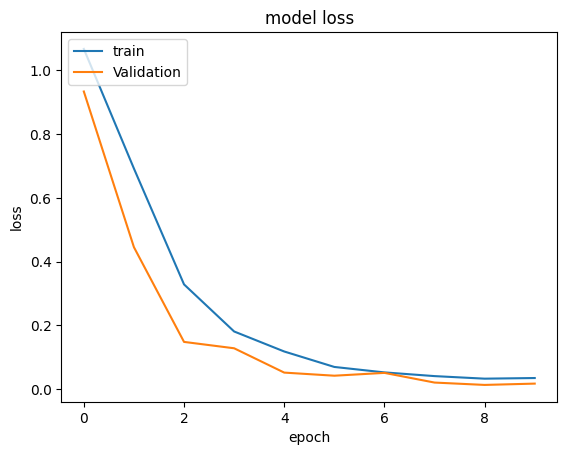

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

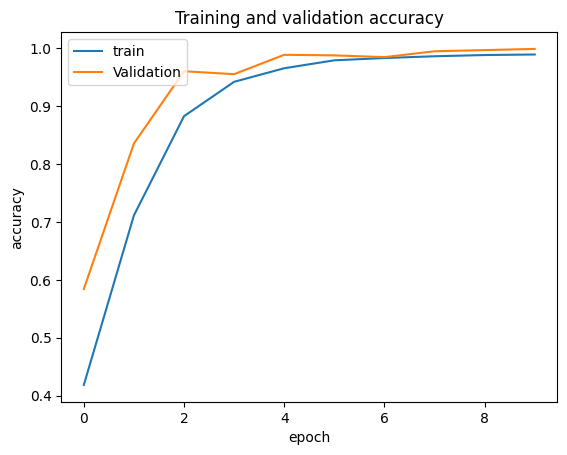

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 6ms/step
[[450  11  35]
 [  1 438  32]
 [  1   0 419]]
0.9423215573179524
0.94292488117152
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       496
           1       0.98      0.93      0.95       471
           2       0.86      1.00      0.92       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.95      0.94      0.94      1387



<Axes: >

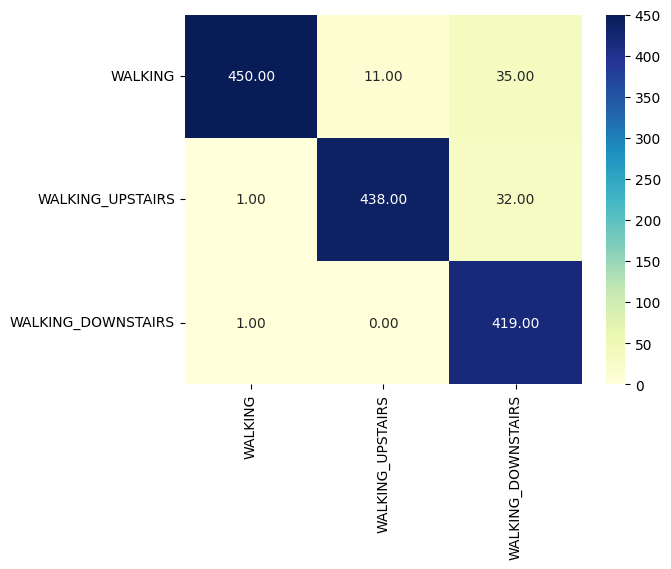

In [42]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

